In [6]:
# python -m pip install geopy
# python -m pip install geopandas


In [47]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
# import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
df = pd.read_csv('fp-historical-wildfire-data-2006-2021.csv')

# Columns being used

# Most Vunerable FSA regions in Alberta

1.  **fire_year** : Aligns with wildfire seasons and is very consistent. If fire start date and fire extinguished dates are different years then it is confusing and complex to determine which year the fire is.

2.  **size_class** : crucial for assesing severity of wildfires.

3.  **Fire Location Latitude & Longitude** : provide accurate geographical coordinates of fire.

4.  **fire_number** : contains information about the regions of fire occurance.

5.  **fire_start_date** : indicates fire start date (using it for duration of fire).

6.  **ex_fs_date** : fire extinguished date (using it for duration of fire).

7.  **current_size** : Indicates the final area burned by the wildfire.


## Most Vunerable FSA regions in Alberta (Data Analysis)

1.   Create heat map (2006-2021) of fire using **fire_number**. Map regions using the **fire_number** code to get the regions.

2.   Create interactive heat map using **fire_year**, **Fire Location Latitude & Longitude**, and **size_class**. We can specify the **fire_year**, **size_class**. *Possibly calculate average fire duration for each fire class*


## Data Cleaning (Most Vunerable FSA regions in Alberta)

In [10]:
# function to show class of fire size
def give_size_class(num):
    if num <= 0.1:
        return 'A'
    elif num <= 4.0:
        return 'B'
    elif num <= 40.0:
        return 'C'
    elif num <= 200:
        return 'D'
    else:
        return 'E'

In [11]:
df_map = df[["fire_year", "fire_location_latitude", "fire_location_longitude", "current_size" , "size_class", "fire_number", "fire_start_date", "ex_fs_date"]]

### Data Cleaning (Most Vunerable FSA regions in Alberta) - Cleaning Date Columns

In [12]:
# we wil use this function when we are cleaning dates for "fire_start_date" and "ex_fs_date"
# the function will return pd.NaT for null values.
def correct_date_string(date_str):
    # Check if the date_str is not a string (e.g., NaN represented as float)
    if not isinstance(date_str, str):
        return pd.NaT  # Return Not a Time for pandas

    # Split the date string into components
    parts = date_str.split('/')

    # Correct the month part
    month = parts[0]
    month = str(max(min(int(month), 12), 1)).zfill(2)  # Ensure month is between 01 and 12

    # Correct the day part
    day = parts[1]
    day = str(max(min(int(day), 31), 1)).zfill(2)  # Ensure day is between 01 and 31

    # Adjust the year part to use the last two digits
    year = parts[2].split(' ')[0]  # Extract year part only, ignoring time if present
    if len(year) == 4:  # If year is mistakenly input as 4 digits
        year = year[-2:]  # Use last two digits

    # Reconstruct the date string, including time part if present
    corrected_date_str = f"{month}/{day}/{year}"
    if len(parts[2].split(' ')) > 1:  # If there's a time part
        time_part = parts[2].split(' ')[1]  # Extract time part
        corrected_date_str += f" {time_part}"

    return corrected_date_str

In [13]:

# Now apply the corrected function
#df_map['fire_start_date'] = df_map['fire_start_date'].apply(correct_date_string)
#df_map['ex_fs_date'] = df_map['ex_fs_date'].apply(correct_date_string)

In [14]:
# Convert to datetime, errors='coerce' will handle any remaining issues by converting them to NaT
#df_map['fire_start_date'] = pd.to_datetime(df_map['fire_start_date'], format='%m/%d/%y %H:%M', errors='coerce')
#df_map['ex_fs_date'] = pd.to_datetime(df_map['ex_fs_date'], format='%m/%d/%y %H%M', errors='coerce')

In [15]:
df_map.loc[df_map['fire_start_date'].isna()].groupby(['size_class']).size().reset_index(name='count')
# it looks like we have null values in fire_start_date and these are the distribution of the size_class
# for now, we will keep them but when we use this column to calculate the duration we will remove these columns.

,size_class,count
0,A,611
1,B,6
2,C,2
3,E,1


In [16]:
  # checking bad date values
  #df_map.loc[df_map['fire_start_date']=='04/24/1021 12:00:00']

### Data Cleaning (Most Vunerable FSA regions in Alberta) - Mapping regions

In [17]:
# given region code, outputs the region
locations = {
    "C": "Calgary",
    "E": "Edson",
    "H": "High Level",
    "G": "Grande Prairie",
    "L": "Lac La Biche",
    "M": "Fort McMurray",
    "P": "Peace River",
    "R": "Rocky",
    "S": "Slave Lake",
    "W": "Whitecourt"
}

In [18]:
def map_region (fire_num) :
  # Extract the first letter from the code
    first_letter = fire_num[0]

    # Use the first letter to get the corresponding location from the dictionary
    # If the letter is not found, return a default value like "Unknown location"
    return locations.get(first_letter, "Unknown location")

In [19]:
# function that uses "location" to map the Regions using fire_number
df_map.loc[:, 'fire_regions'] = df_map['fire_number'].apply(map_region)

C:\Users\paulp\AppData\Local\Temp\ipykernel_18244\4202445441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map.loc[:, 'fire_regions'] = df_map['fire_number'].apply(map_region)


In [20]:
df_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22914 entries, 0 to 22913
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fire_year                22914 non-null  int64  
 1   fire_location_latitude   22914 non-null  float64
 2   fire_location_longitude  22914 non-null  float64
 3   current_size             22914 non-null  float64
 4   size_class               22914 non-null  object 
 5   fire_number              22914 non-null  object 
 6   fire_start_date          22294 non-null  object 
 7   ex_fs_date               22914 non-null  object 
 8   fire_regions             22914 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 1.6+ MB


In [21]:
# create new data frame with fire_regions, fire_year, fire_count
df_regions_map = df_map[["fire_year","fire_regions"]]
df_regions_map = df_regions_map.groupby(["fire_year", "fire_regions"]).size().reset_index(name="fire_count")

## Plots (Most Vunerable FSA regions in Alberta)

Geographic map plot is going to be plotted via Power BI

In [39]:
tmp = df_regions_map.groupby('fire_regions').sum().reset_index()
tmp.drop(columns=['fire_year'],inplace=True)

### Plot - Most popular fire count in Alberta over 2006 to 2021

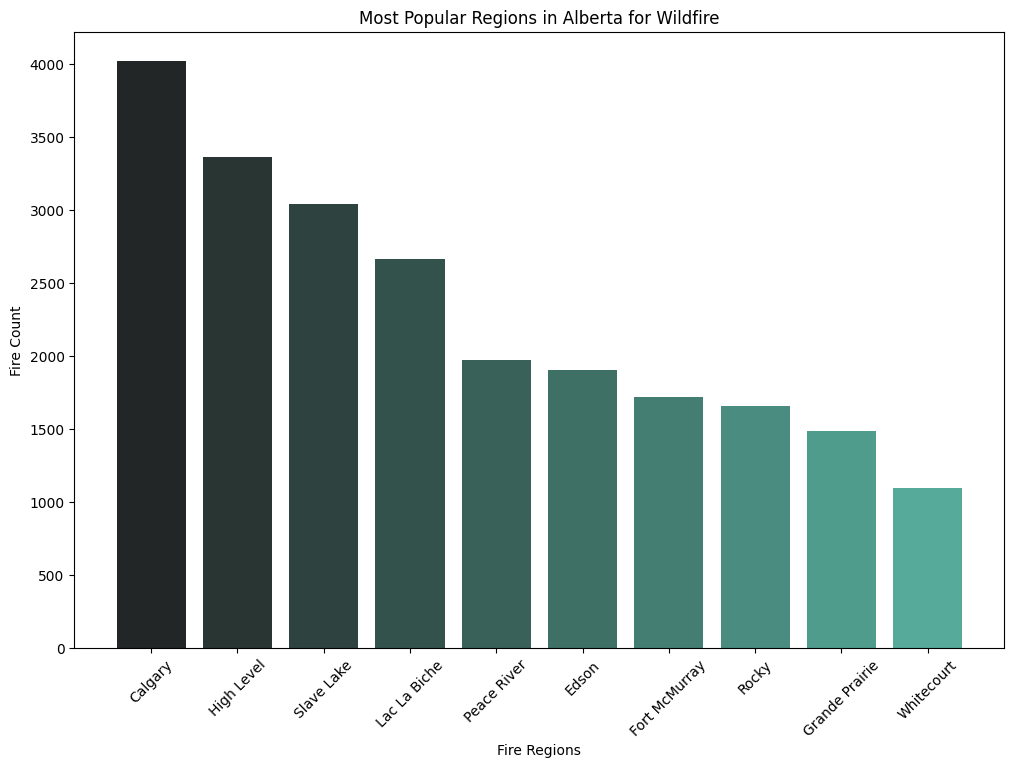

In [49]:
# Sort the DataFrame based on 'fire_count' in descending order
sorted_tmp = tmp.sort_values('fire_count', ascending=False)

# Create a darker color palette with a distinct color for each region
# Using the 'dark' palette and setting the 'desat' parameter to decrease saturation
palette = sns.color_palette("dark:#5A9", len(sorted_tmp['fire_regions']), desat=1)

# Create a bar plot with different colors for each bar
plt.figure(figsize=(12, 8))  # Adjust the size as per your requirement
plt.bar(sorted_tmp['fire_regions'], sorted_tmp['fire_count'], color=palette)

# Add labels and title
plt.xlabel('Fire Regions')
plt.ylabel('Fire Count')
plt.title('Most Popular Regions in Alberta for Wildfire (2006 - 2021)')
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap

# Show the plot
plt.show()


### Plot -  line graph of all regions in Alberta

In [57]:
tmp = df_regions_map.groupby('fire_year').sum().reset_index()
tmp.drop(columns=["fire_regions"],inplace=True)

Text(0.5, 1.0, 'Trend in Fires by Region')

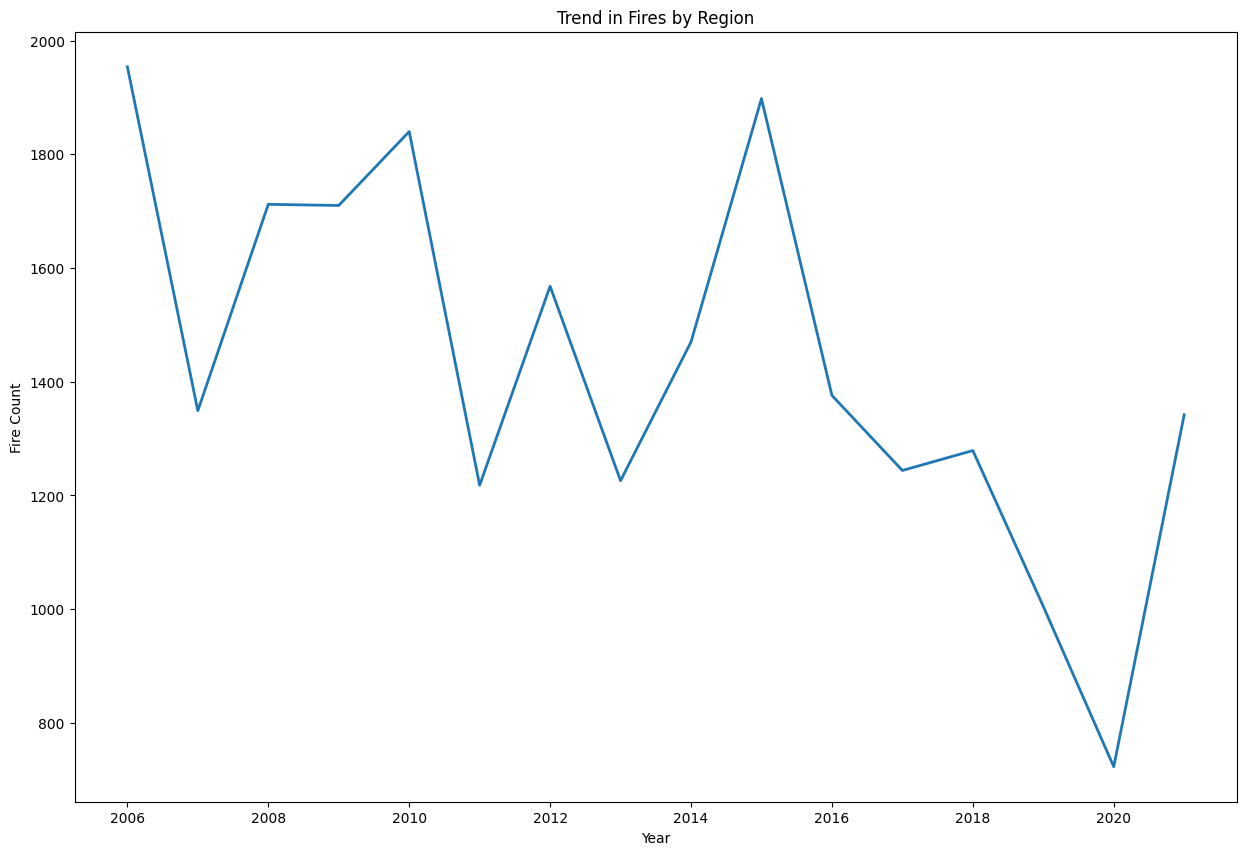

In [59]:
# Pivot the DataFrame to have years as the index and regions as the columns
# with fire counts as the values
plt.figure(figsize=(15, 10))
plt.plot(tmp['fire_year'], tmp['fire_count'], marker='', linewidth=2, label=column)


# Add labels and title
plt.xlabel('Year')
plt.ylabel('Fire Count')
plt.title('Alberta Fire Trend 2006-2021')

Text(0.5, 1.0, 'Trend in Fires by Region')

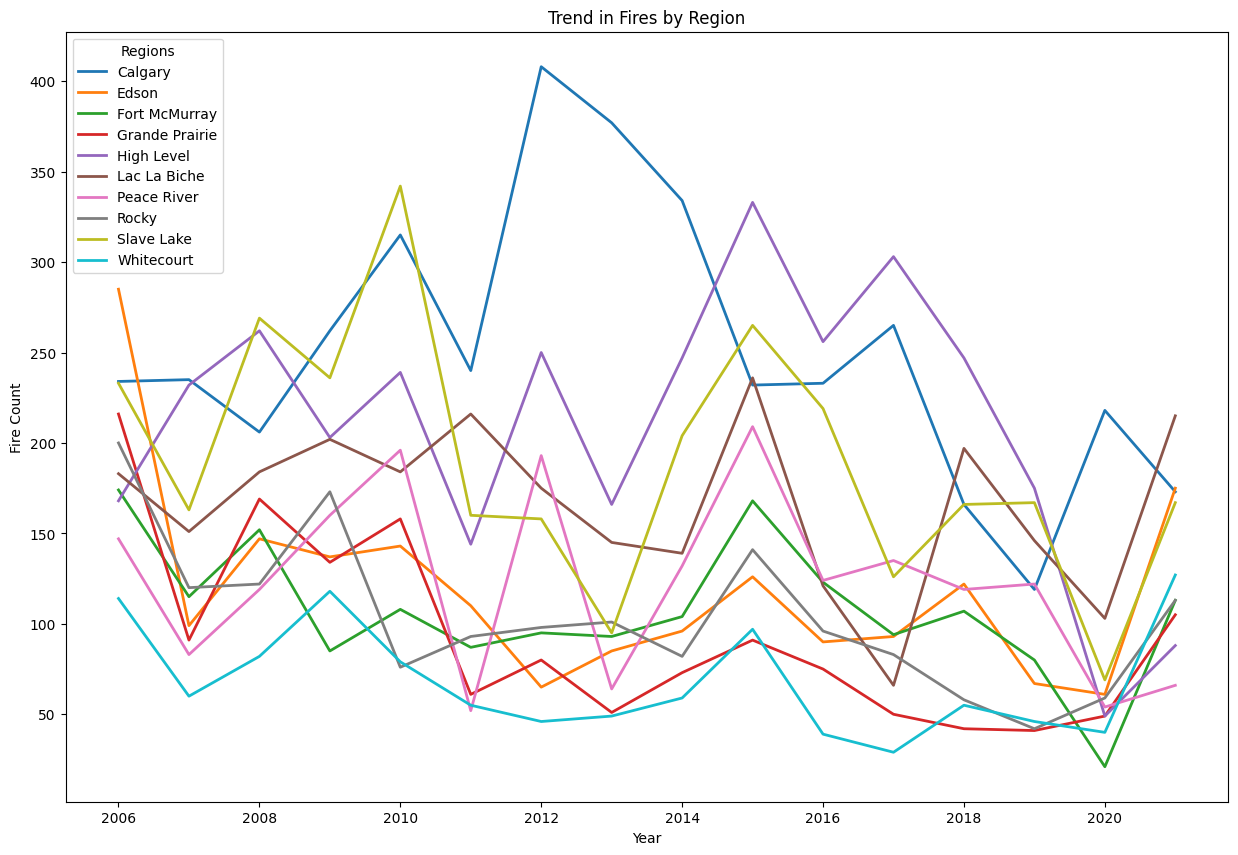

In [50]:
# Pivot the DataFrame to have years as the index and regions as the columns
# with fire counts as the values
pivot_df = df_regions_map.pivot_table(index='fire_year', columns='fire_regions', values='fire_count', aggfunc='sum')

# Plotting each region's trend line in the same graph
plt.figure(figsize=(15, 10))

for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], marker='', linewidth=2, label=column)

# Add legend
plt.legend(loc='upper left', title='Regions')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Fire Count')
plt.title('Trend in Fires by Region')

# Main Reasons of Fire, large burn areas, significant enviornmental and residential impact

1.  **Fire Number (fire_number):**

Uniquely identifies each wildfire incident, allowing for specific tracking and analysis of individual fires.

2.  **Current Size (current_size):**

Indicates the final area burned by the wildfire, essential for identifying fires with large burn areas and assessing their potential impact.

3.  **Size Class (size_class):**

Classifies wildfires based on the final area burned, helping to quickly identify the scale of wildfires (from very small to very large) for prioritization and analysis.

4.  **Fire Location Latitude & Longitude (fire_location_latitude, fire_location_longitude):**

Provides precise geographical coordinates of the wildfire's ignition point, crucial for mapping wildfires to specific FSA regions and analyzing spatial patterns of fire occurrence.

5.  **Fire Origin (fire_origin):**

Identifies who owns or administers the land where the wildfire started, which can impact the response strategy and potential resources available for firefighting efforts.


6.  **General Cause Description (general_cause_desc):**

Offers a broad classification of the wildfire's cause, useful for identifying general trends in wildfire ignition sources across different regions.

7.  **Industry Identifier Description (industry_identifier_desc):**

Gives further detail about the specific industry responsible for the wildfire when applicable, allowing for targeted measures in industries frequently associated with wildfire causes.

8.  **Responsible Group Description (responsible_group_desc):**

Specifies the group responsible for causing the wildfire, particularly relevant for fires started due to recreational activities, enabling targeted education and prevention efforts.

9.  **Activity Class (activity_class):**

Details the specific activity that led to the wildfire's ignition, providing insights into preventable behaviors or practices that may need regulation or awareness campaigns.

10. **True Cause (true_cause):**

Pinpoints the exact reason why the wildfire started, offering the most direct insight into preventable causes and potential areas for intervention.



